In [ ]:
import pandas as pd
import tensorflow as tf
import keras
import seaborn as sns

# Data and Preprocessing


In [ ]:
data = pd.read_csv('bank-additional-full.csv', sep=";", na_values="unknown")
data = data.rename(columns=lambda x: x.strip())

In [ ]:
"""
Introduction:
Given customers information and data about their campaign contact --> predict if they will say yes to campaign
What is likely a good predictor
education might be good, job might be good age sounds great.


Possible processing
Age -> bin
Job -> one hot
marital -> one hot
education -> one hot
default -> one hot with unknown
housing loan -> one hot with unknown
loan -> one hot with unknown (maybe set unknown to no might be fine?)

contact -> 0/1
month -> last contact month so --> onehot?
day_of_week -> one hot  --> imo this is a useless column --> but onehot?
duration --> drop because not realistic

campaign --> numerical --> absolutely probably needed
pdays --> might be good to set an extra flag for 999 --> may need to standardized  cus numeric --> change flag to -1 or sth
previous --> this is probably directly correlated with previous 2, these 3 items are all correlated
poutcome --> one hot but all 4 in this categories are very correlated MAYBE HAVING POUTCOME is enough


imo it might be possible to simply standardized these items
emp.var.rate --> leave it
cons.price.idx --> leave it
cons.conf.idx --> leave it for now
euribor3m --> leave it
nr.employed --> leave it


with so many one hot u may need like 512 or 1024 nodes per layer

Possible unknown checking
impute --> jobs, marital, default, housing, loan (low data counts)
default/education --> for now let's make it zero and flag it
"""
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [ ]:
data['y'] = data['y'].apply(lambda x: 0 if x.strip() == 'no' else 1)

In [ ]:
"""
cleaning for item related
Age -> bin
Job -> one hot
marital -> one hot
education -> one hot
default -> one hot with unknown
housing loan -> one hot with unknown
loan
age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
"""
# impute data for job, marital, housing, loan
# for education and default we shall one hot encode the na values
imputed_df = data.dropna(subset=["job", "marital", "housing", "loan"])

In [ ]:
print(data.shape, imputed_df.shape)

(41188, 21) (39803, 21)


In [ ]:
imputed_df['age'].describe()

count    39803.000000
mean        39.980228
std         10.402670
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64

In [ ]:
#
"""
preprocess for item related to cusomter
age -> bin
job -> one hot
marital -> one hot
education -> one hot
default -> one hot with unknown
housing loan -> one hot with unknown
loan
"""
column_processed = ["age_binned"]
# based on  imputed_df['age'].describe()
age_bins = [i for i in range(15, 101, 5)]
imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])
imputed_df_dummy = pd.get_dummies(imputed_df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan'],
                                  dummy_na=True)


<ipython-input-8-5429ec2f6224>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])


In [ ]:

basic_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'age_binned', 'y']
chosen_columns = pd.Series(imputed_df_dummy.columns)
chosen_columns = chosen_columns[chosen_columns.apply(lambda x: any([x.startswith(b) for b in basic_columns]))]
chosen_df = imputed_df_dummy[chosen_columns]

In [ ]:
chosen_df

,y,age_binned,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,education_nan,default_no,default_yes,default_nan,housing_no,housing_yes,housing_nan,loan_no,loan_yes,loan_nan
0,0,8,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0,8,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0
2,0,4,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0
3,0,4,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0,8,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1,11,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
41184,0,6,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
41185,0,8,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
41186,1,5,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


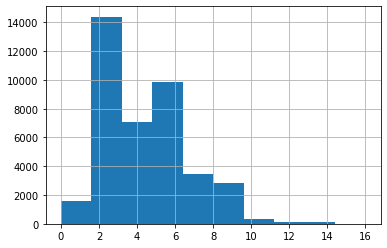

In [ ]:
chosen_df['age_binned'].hist()

## Standardize some numerical values
we shall standardize some items that are not flagged items (eg age bins, age, etc)

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
predict_column = 'y'
train_df, test_df = train_test_split(chosen_df, train_size=0.7, stratify=chosen_df[predict_column])
test_df, val_df = train_test_split(test_df, train_size=0.5, stratify=test_df[predict_column])
columns_to_standardized = [c for c in chosen_df.columns if c != predict_column]
scaler = preprocessing.StandardScaler()
train_df[columns_to_standardized] = scaler.fit_transform(train_df[columns_to_standardized])
test_df[columns_to_standardized] = scaler.transform(test_df[columns_to_standardized])
val_df[columns_to_standardized] = scaler.transform(val_df[columns_to_standardized])
train_data = (train_df[columns_to_standardized].values, train_df[predict_column].values)
test_data = (test_df[columns_to_standardized].values, test_df[predict_column].values)
val_data = (val_df[columns_to_standardized].values, val_df[predict_column].values)

In [ ]:
print(train_df[predict_column].value_counts(normalize=True))
print(test_df[predict_column].value_counts(normalize=True))
print(val_df[predict_column].value_counts(normalize=True))

0    0.887266
1    0.112734
Name: y, dtype: float64
0    0.88727
1    0.11273
Name: y, dtype: float64
0    0.887289
1    0.112711
Name: y, dtype: float64


## Training

In [ ]:
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sklearn as sk

In [ ]:
RECALL_METRIC = tf.keras.metrics.Recall(name='recall')
AUC_METRIC = keras.metrics.AUC(name='auc')

In [ ]:
def scheduler(epoch, lr):
  if epoch < 4:
    return lr
  return lr * tf.math.exp(-0.1)

def create_network_for_binary_classification_only_3_hidden_layers(no_features,
                                                                units_each_layer,
                                                                regularization=None,
                                                                dropouts_each_layer=None):
  no_features = len(columns_to_standardized)
  network = models.Sequential()
  network.add(layers.Dense(units=units_each_layer[0], 
                           activation='relu', 
                           kernel_regularizer=regularization,
                           input_shape=(no_features,)))
  if dropouts_each_layer is not None and dropouts_each_layer[0] > 0:
    network.add(layers.Dropout(dropouts_each_layer[0]))
  network.add(layers.Dense(units=units_each_layer[1], 
                           kernel_regularizer=regularization,
                           activation='relu'))
  if dropouts_each_layer is not None and dropouts_each_layer[1] > 0:
    network.add(layers.Dropout(dropouts_each_layer[1]))
  network.add(layers.Dense(units=units_each_layer[2], 
                           kernel_regularizer=regularization,
                           activation='relu'))
  if dropouts_each_layer is not None and dropouts_each_layer[2] > 0:
    network.add(layers.Dropout(dropouts_each_layer[2]))
  network.add(layers.Dense(units=1, activation='sigmoid'))
  
  
  network.compile(loss='binary_crossentropy' , 
                  optimizer = 'rmsprop', 
                  metrics = ['accuracy', RECALL_METRIC, AUC_METRIC])
  return network

In [ ]:
columns_train = columns_to_standardized
no_features = len(columns_train)
units = [16, 16, 16]
network = create_network_for_binary_classification_only_3_hidden_layers(no_features, units)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             lr_callback]
            # ModelCheckpoint(filepath='best_mode.h5', monitor='val_loss', save_best_only=True),
            # ModelCheckpoint(filepath='best_recall.h5', monitor='val_recall', save_best_only=True)]
history = network.fit(train_data[0], 
                      train_data[1],
                      epochs = 10,
                      verbose=1,
                      batch_size=64,
                      validation_data=val_data)

Epoch 1/10
436/436 [==============================] - 2s 2ms/step - loss: 0.3844 - accuracy: 0.8645 - recall: 0.0385 - auc: 0.5681 - val_loss: 0.3446 - val_accuracy: 0.8873 - val_recall: 0.0000e+00 - val_auc: 0.6249
Epoch 2/10
436/436 [==============================] - 1s 2ms/step - loss: 0.3399 - accuracy: 0.8873 - recall: 0.0000e+00 - auc: 0.6365 - val_loss: 0.3413 - val_accuracy: 0.8873 - val_recall: 0.0000e+00 - val_auc: 0.6359
Epoch 3/10
436/436 [==============================] - 1s 1ms/step - loss: 0.3378 - accuracy: 0.8871 - recall: 6.3674e-04 - auc: 0.6433 - val_loss: 0.3401 - val_accuracy: 0.8873 - val_recall: 0.0000e+00 - val_auc: 0.6430
Epoch 4/10
436/436 [==============================] - 1s 2ms/step - loss: 0.3368 - accuracy: 0.8872 - recall: 0.0025 - auc: 0.6466 - val_loss: 0.3405 - val_accuracy: 0.8873 - val_recall: 0.0045 - val_auc: 0.6450
Epoch 5/10
436/436 [==============================] - 1s 2ms/step - loss: 0.3359 - accuracy: 0.8874 - recall: 0.0076 - auc: 0.6504 -

# Visualization of Training History and Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def get_loss_information(history):
  training_loss = history.history["loss"]
  test_loss = history.history["val_loss"]
  epoch_count = range(1, len(training_loss)+1)
  return training_loss, test_loss, epoch_count

def get_acc_information(history):
  training_accuracy = history.history['accuracy']
  test_accuracy = history.history['val_accuracy']
  epoch_count = range(1, len(training_accuracy)+1)
  return training_accuracy, test_accuracy, epoch_count

def get_information_for_plot(history, name):
  training_accuracy = history.history[name]
  test_accuracy = history.history['val_{}'.format(name)]
  epoch_count = range(1, len(training_accuracy)+1)
  return training_accuracy, test_accuracy, epoch_count

def plot_train_test_comparison(training, test, epoch_count, metric_title="loss"):
  plt.figure()
  plt.plot(epoch_count, training, 'r--')
  plt.plot(epoch_count, test, 'b-')
  plt.legend(["Training {}".format(metric_title), "Test {}".format(metric_title)])
  plt.plot() 
  plt.title("validation {0} vs trainig {0}".format(metric_title))

def plot_confusion_matrix(network,
                          test_data,
                          labels=[0, 1]):
  predicted_target = predict_and_convert(network, test_data)
  cm = confusion_matrix(test_data[1], predicted_target, labels=[0, 1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
  plt.figure()
  disp.plot()
  plt.title("Confusion matrix of network")

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sk.metrics.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

def predict_and_convert(network, test_data):
  predicted_target = network.predict(test_data[0])
  predicted_target[predicted_target >= RECALL_METRIC.thresholds] = 1
  predicted_target[predicted_target < RECALL_METRIC.thresholds] = 0
  return predicted_target

In [ ]:
training_loss, test_loss, epoch_count = get_information_for_plot(history, 'loss')
training_acc, test_acc, epoch_count = get_information_for_plot(history, 'accuracy')
training_recall, test_recall, epoch_count = get_information_for_plot(history, 'recall')

187/187 [==============================] - 0s 748us/step


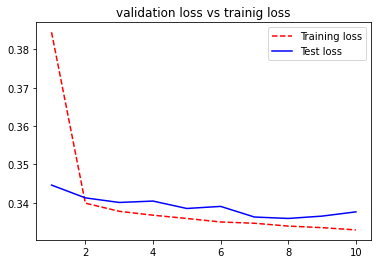

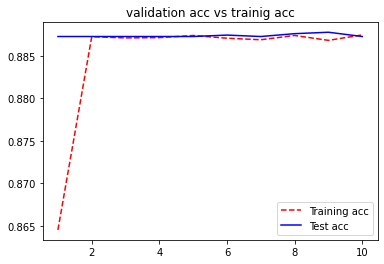

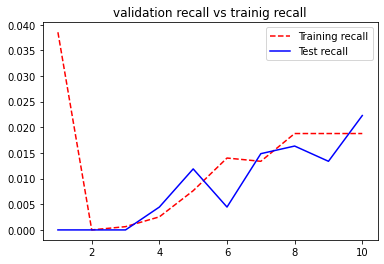

<Figure size 432x288 with 0 Axes>

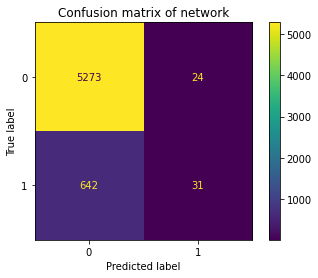

In [ ]:
plot_train_test_comparison(training_loss, test_loss, epoch_count)
plot_train_test_comparison(training_acc, test_acc, epoch_count, metric_title="acc")
plot_train_test_comparison(training_recall, test_recall, epoch_count, metric_title="recall")
plot_confusion_matrix(network, test_data)

In [ ]:
from keras import regularizers

Epoch 1/5
436/436 [==============================] - 3s 3ms/step - loss: 0.3475 - accuracy: 0.8859 - recall: 0.0126 - auc: 0.6188 - val_loss: 0.3472 - val_accuracy: 0.8846 - val_recall: 0.0431 - val_auc: 0.6463
Epoch 2/5
436/436 [==============================] - 1s 3ms/step - loss: 0.3409 - accuracy: 0.8872 - recall: 0.0159 - auc: 0.6338 - val_loss: 0.3482 - val_accuracy: 0.8873 - val_recall: 0.0015 - val_auc: 0.6430
Epoch 3/5
436/436 [==============================] - 1s 3ms/step - loss: 0.3388 - accuracy: 0.8871 - recall: 0.0188 - auc: 0.6417 - val_loss: 0.3414 - val_accuracy: 0.8876 - val_recall: 0.0119 - val_auc: 0.6387
Epoch 4/5
436/436 [==============================] - 1s 3ms/step - loss: 0.3372 - accuracy: 0.8870 - recall: 0.0239 - auc: 0.6486 - val_loss: 0.3379 - val_accuracy: 0.8880 - val_recall: 0.0119 - val_auc: 0.6506
Epoch 5/5
187/187 [==============================] - 0s 872us/step


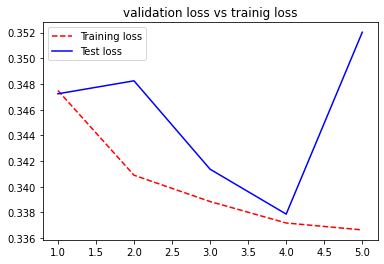

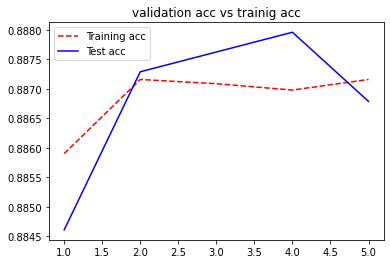

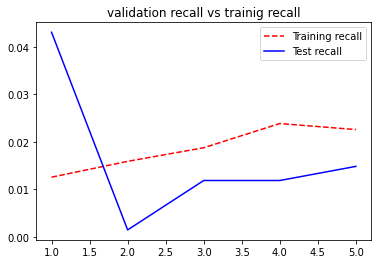

<Figure size 432x288 with 0 Axes>

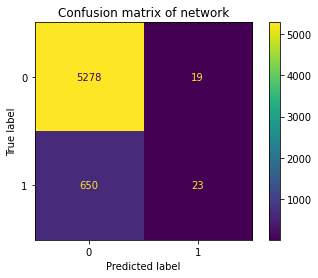

In [ ]:
columns_train = columns_to_standardized
no_features = len(columns_train)
units = [256, 256, 64]
network = create_network_for_binary_classification_only_3_hidden_layers(no_features, 
                                                                        units)
history = network.fit(train_data[0], 
                      train_data[1],
                      epochs = 5,
                      verbose=1,
                      batch_size=64,
                      validation_data=val_data,
                      )
training_loss, test_loss, epoch_count = get_information_for_plot(history, 'loss')
training_acc, test_acc, epoch_count = get_information_for_plot(history, 'accuracy')
training_recall, test_recall, epoch_count = get_information_for_plot(history, 'recall')
plot_train_test_comparison(training_loss, test_loss, epoch_count)
plot_train_test_comparison(training_acc, test_acc, epoch_count, metric_title="acc")
plot_train_test_comparison(training_recall, test_recall, epoch_count, metric_title="recall")
plot_confusion_matrix(network, test_data)

## Add more feature round 1

add other attributes set

campaign = simply standardize

pdays = create new column call is_contacted_pday to flag 999, otherwise simply standardize

previous = standardize

poutcome = one-hot


as we can see from results, the recall get way better than when we simply use 

In [ ]:
# basicall we add more columns
basic_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                 'age_binned', 'poutcome', 'previous', 'campaign', 'pdays', 'is_contacted_pdays',
                 'y']

# one hot columns
one_hot_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']

column_processed = ["age_binned"]
# based on  imputed_df['age'].describe()
age_bins = [i for i in range(15, 101, 5)]
imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])
imputed_df_dummy = pd.get_dummies(imputed_df, columns=one_hot_columns,
                                  dummy_na=True)
if 'pdays' in basic_columns:
  imputed_df_dummy['is_contacted_pdays'] = imputed_df_dummy['pdays'].apply(lambda x: 0 if x != 999 else 1)

chosen_columns = pd.Series(imputed_df_dummy.columns)
chosen_columns = chosen_columns[chosen_columns.apply(lambda x: any([x.startswith(b) for b in basic_columns]))]
chosen_df = imputed_df_dummy[chosen_columns]

<ipython-input-25-23f7dcd6d959>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])


In [ ]:
predict_column = 'y'
train_df, test_df = train_test_split(chosen_df, train_size=0.7, stratify=chosen_df[predict_column])
test_df, val_df = train_test_split(test_df, train_size=0.5, stratify=test_df[predict_column])
columns_to_standardized = [c for c in chosen_df.columns if c != predict_column]
scaler = preprocessing.StandardScaler()
train_df[columns_to_standardized] = scaler.fit_transform(train_df[columns_to_standardized])
test_df[columns_to_standardized] = scaler.transform(test_df[columns_to_standardized])
val_df[columns_to_standardized] = scaler.transform(val_df[columns_to_standardized])
train_data = (train_df[columns_to_standardized].values, train_df[predict_column].values)
test_data = (test_df[columns_to_standardized].values, test_df[predict_column].values)
val_data = (val_df[columns_to_standardized].values, val_df[predict_column].values)

Epoch 1/10
436/436 [==============================] - 3s 5ms/step - loss: 0.6923 - accuracy: 0.8951 - recall: 0.1190 - auc: 0.6607 - val_loss: 0.3334 - val_accuracy: 0.8982 - val_recall: 0.2036 - val_auc: 0.6880
Epoch 2/10
436/436 [==============================] - 2s 4ms/step - loss: 0.3306 - accuracy: 0.8977 - recall: 0.1767 - auc: 0.6732 - val_loss: 0.3328 - val_accuracy: 0.8937 - val_recall: 0.0966 - val_auc: 0.6913
Epoch 3/10
436/436 [==============================] - 2s 4ms/step - loss: 0.3269 - accuracy: 0.8975 - recall: 0.1773 - auc: 0.6808 - val_loss: 0.3266 - val_accuracy: 0.8983 - val_recall: 0.2036 - val_auc: 0.6908
Epoch 4/10
436/436 [==============================] - 2s 4ms/step - loss: 0.3247 - accuracy: 0.8977 - recall: 0.1808 - auc: 0.6842 - val_loss: 0.3259 - val_accuracy: 0.8985 - val_recall: 0.2036 - val_auc: 0.6946
Epoch 5/10
436/436 [==============================] - 2s 4ms/step - loss: 0.3242 - accuracy: 0.8979 - recall: 0.1837 - auc: 0.6801 - val_loss: 0.3239 - 

Text(0.5, 1.0, 'roc curve with various baselines')

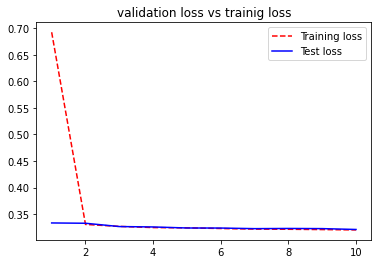

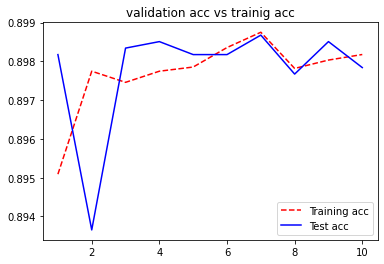

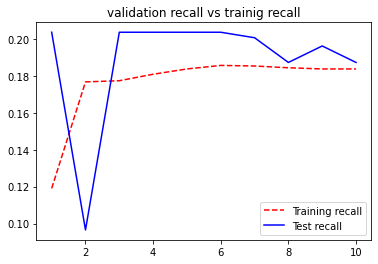

<Figure size 432x288 with 0 Axes>

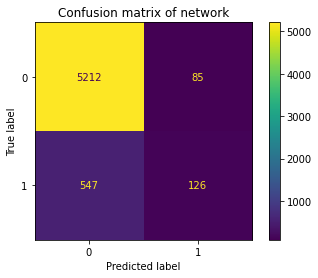

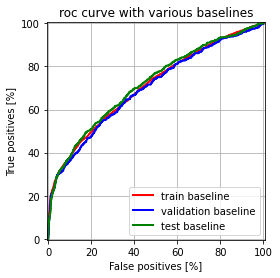

In [ ]:
columns_train = columns_to_standardized
no_features = len(columns_train)
units = [512, 256, 64]
network = create_network_for_binary_classification_only_3_hidden_layers(no_features, 
                                                                        units,
                                                                        regularization=regularizers.l2(0.01))
history = network.fit(train_data[0], 
                      train_data[1],
                      epochs = 10,
                      verbose=1,
                      batch_size=64,
                      validation_data=val_data,
                      )
training_loss, test_loss, epoch_count = get_information_for_plot(history, 'loss')
training_acc, test_acc, epoch_count = get_information_for_plot(history, 'accuracy')
training_recall, test_recall, epoch_count = get_information_for_plot(history, 'recall')
plot_train_test_comparison(training_loss, test_loss, epoch_count)
plot_train_test_comparison(training_acc, test_acc, epoch_count, metric_title="acc")
plot_train_test_comparison(training_recall, test_recall, epoch_count, metric_title="recall")
plot_confusion_matrix(network, test_data)

plt.figure()
plot_roc("train baseline", train_data[1], network.predict(train_data[0]), color='r')
plot_roc("validation baseline", val_data[1], network.predict(val_data[0]), color='b')
plot_roc("test baseline", test_data[1], network.predict(test_data[0]), color='g')
plt.legend(loc='lower right');
plt.title('roc curve with various baselines')

## Add more features round 2
add economic attributes 

all of them are numerical so standardize only

In [ ]:
# basicall we add more columns
basic_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                 'age_binned', 'poutcome', 'previous', 'campaign', 'pdays', 'is_contacted_pdays' 
                 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                 'euribor3m', 'nr.employed','y']

# one hot columns
one_hot_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']

column_processed = ["age_binned"]
# based on  imputed_df['age'].describe()
age_bins = [i for i in range(15, 101, 5)]
imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])
imputed_df_dummy = pd.get_dummies(imputed_df, columns=one_hot_columns,
                                  dummy_na=True)

if 'pdays' in basic_columns:
  imputed_df_dummy['is_contacted_pdays'] = imputed_df_dummy['pdays'].apply(lambda x: 0 if x != 999 else 1)

chosen_columns = pd.Series(imputed_df_dummy.columns)
chosen_columns = chosen_columns[chosen_columns.apply(lambda x: any([x.startswith(b) for b in basic_columns]))]
chosen_df = imputed_df_dummy[chosen_columns]

<ipython-input-28-30907c373dfc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])


In [ ]:
predict_column = 'y'
train_df, test_df = train_test_split(chosen_df, train_size=0.7, stratify=chosen_df[predict_column])
test_df, val_df = train_test_split(test_df, train_size=0.5, stratify=test_df[predict_column])
columns_to_standardized = [c for c in chosen_df.columns if c != predict_column]
scaler = preprocessing.StandardScaler()
train_df[columns_to_standardized] = scaler.fit_transform(train_df[columns_to_standardized])
test_df[columns_to_standardized] = scaler.transform(test_df[columns_to_standardized])
val_df[columns_to_standardized] = scaler.transform(val_df[columns_to_standardized])
train_data = (train_df[columns_to_standardized].values, train_df[predict_column].values)
test_data = (test_df[columns_to_standardized].values, test_df[predict_column].values)
val_data = (val_df[columns_to_standardized].values, val_df[predict_column].values)

Epoch 1/10
436/436 [==============================] - 3s 5ms/step - loss: 0.6868 - accuracy: 0.8946 - recall: 0.1521 - auc: 0.7473 - val_loss: 0.3189 - val_accuracy: 0.8998 - val_recall: 0.1917 - val_auc: 0.7533
Epoch 2/10
436/436 [==============================] - 2s 4ms/step - loss: 0.3134 - accuracy: 0.8968 - recall: 0.1770 - auc: 0.7635 - val_loss: 0.3100 - val_accuracy: 0.8980 - val_recall: 0.2288 - val_auc: 0.7479
Epoch 3/10
436/436 [==============================] - 2s 4ms/step - loss: 0.3081 - accuracy: 0.8965 - recall: 0.1796 - auc: 0.7650 - val_loss: 0.3060 - val_accuracy: 0.8997 - val_recall: 0.2110 - val_auc: 0.7600
Epoch 4/10
436/436 [==============================] - 2s 4ms/step - loss: 0.3052 - accuracy: 0.8977 - recall: 0.1878 - auc: 0.7634 - val_loss: 0.3018 - val_accuracy: 0.9000 - val_recall: 0.1976 - val_auc: 0.7584
Epoch 5/10
436/436 [==============================] - 2s 4ms/step - loss: 0.3027 - accuracy: 0.8971 - recall: 0.1862 - auc: 0.7675 - val_loss: 0.3019 - 

Text(0.5, 1.0, 'roc curve with various baselines')

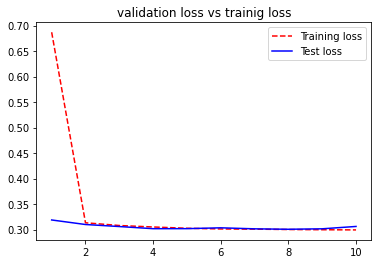

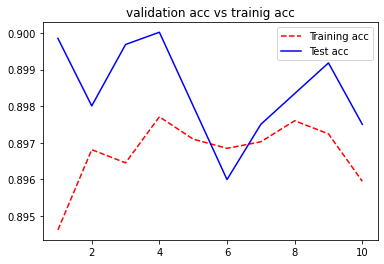

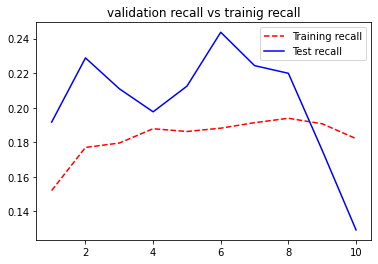

<Figure size 432x288 with 0 Axes>

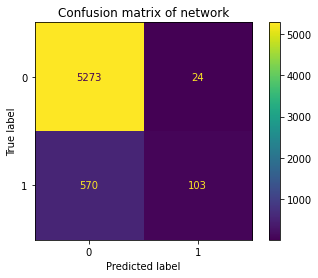

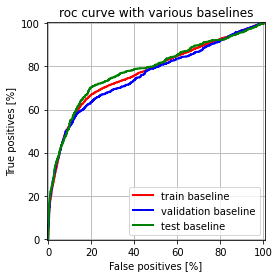

In [ ]:
columns_train = columns_to_standardized
no_features = len(columns_train)
units = [512, 256, 64]
network = create_network_for_binary_classification_only_3_hidden_layers(no_features, 
                                                                        units,
                                                                        regularization=regularizers.l2(0.01))
history = network.fit(train_data[0], 
                      train_data[1],
                      epochs = 10,
                      verbose=1,
                      batch_size=64,
                      validation_data=val_data,
                      )
training_loss, test_loss, epoch_count = get_information_for_plot(history, 'loss')
training_acc, test_acc, epoch_count = get_information_for_plot(history, 'accuracy')
training_recall, test_recall, epoch_count = get_information_for_plot(history, 'recall')
plot_train_test_comparison(training_loss, test_loss, epoch_count)
plot_train_test_comparison(training_acc, test_acc, epoch_count, metric_title="acc")
plot_train_test_comparison(training_recall, test_recall, epoch_count, metric_title="recall")
plot_confusion_matrix(network, test_data)

plt.figure()
plot_roc("train baseline", train_data[1], network.predict(train_data[0]), color='r')
plot_roc("validation baseline", val_data[1], network.predict(val_data[0]), color='b')
plot_roc("test baseline", test_data[1], network.predict(test_data[0]), color='g')
plt.legend(loc='lower right');
plt.title('roc curve with various baselines')

# Add more features round 3

In [ ]:
# basicall we add more columns
basic_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                 'age_binned', 'poutcome', 'previous', 'campaign', 'pdays', 'is_contacted_pdays' 
                 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                 'euribor3m',  'nr.employed', 
                 'contact', 'month', 'day_of_week','y']

# one hot columns
one_hot_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome',
                   'month', 'day_of_week']

column_processed = ["age_binned"]
# based on  imputed_df['age'].describe()
age_bins = [i for i in range(15, 101, 5)]
imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])
imputed_df_dummy = pd.get_dummies(imputed_df, columns=one_hot_columns,
                                  dummy_na=True)
if 'contact' in basic_columns:
  imputed_df_dummy['contact'] = imputed_df_dummy['contact'].apply(lambda x: 0 if x != 'cellular' else 1)
if 'pdays' in basic_columns:
  imputed_df_dummy['is_contacted_pdays'] = imputed_df_dummy['pdays'].apply(lambda x: 0 if x != 999 else 1)

chosen_columns = pd.Series(imputed_df_dummy.columns)
chosen_columns = chosen_columns[chosen_columns.apply(lambda x: any([x.startswith(b) for b in basic_columns]))]
chosen_df = imputed_df_dummy[chosen_columns]

<ipython-input-31-7f6ffdd8a91b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])


In [ ]:
predict_column = 'y'
train_df, test_df = train_test_split(chosen_df, train_size=0.7, stratify=chosen_df[predict_column])
test_df, val_df = train_test_split(test_df, train_size=0.5, stratify=test_df[predict_column])
columns_to_standardized = [c for c in chosen_df.columns if c != predict_column]
scaler = preprocessing.StandardScaler()
train_df[columns_to_standardized] = scaler.fit_transform(train_df[columns_to_standardized])
test_df[columns_to_standardized] = scaler.transform(test_df[columns_to_standardized])
val_df[columns_to_standardized] = scaler.transform(val_df[columns_to_standardized])
train_data = (train_df[columns_to_standardized].values, train_df[predict_column].values)
test_data = (test_df[columns_to_standardized].values, test_df[predict_column].values)
val_data = (val_df[columns_to_standardized].values, val_df[predict_column].values)

Epoch 1/10
436/436 [==============================] - 2s 3ms/step - loss: 0.7251 - accuracy: 0.8953 - recall: 0.1605 - auc: 0.7657 - val_loss: 0.3267 - val_accuracy: 0.9010 - val_recall: 0.2288 - val_auc: 0.7877 - lr: 0.0010
Epoch 2/10
436/436 [==============================] - 1s 3ms/step - loss: 0.3058 - accuracy: 0.8981 - recall: 0.2095 - auc: 0.7788 - val_loss: 0.2995 - val_accuracy: 0.8962 - val_recall: 0.2764 - val_auc: 0.7838 - lr: 0.0010
Epoch 3/10
436/436 [==============================] - 1s 3ms/step - loss: 0.3006 - accuracy: 0.8981 - recall: 0.2111 - auc: 0.7800 - val_loss: 0.2969 - val_accuracy: 0.8992 - val_recall: 0.2704 - val_auc: 0.7861 - lr: 0.0010
Epoch 4/10
436/436 [==============================] - 1s 3ms/step - loss: 0.2979 - accuracy: 0.8984 - recall: 0.2159 - auc: 0.7832 - val_loss: 0.2936 - val_accuracy: 0.9009 - val_recall: 0.2125 - val_auc: 0.7841 - lr: 0.0010
Epoch 5/10
436/436 [==============================] - 1s 3ms/step - loss: 0.2962 - accuracy: 0.8982 

Text(0.5, 1.0, 'roc curve with various baselines')

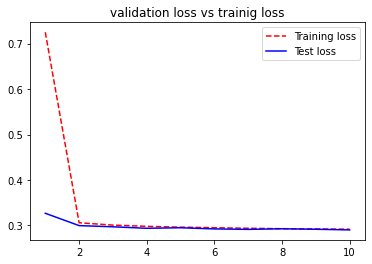

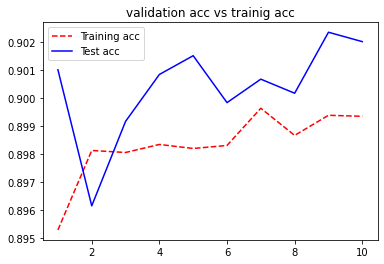

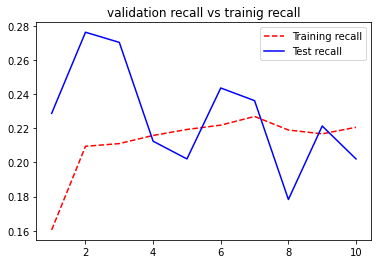

<Figure size 432x288 with 0 Axes>

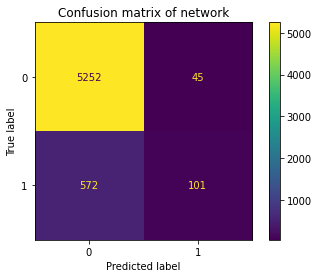

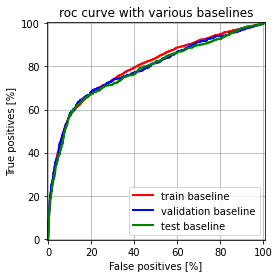

In [ ]:
columns_train = columns_to_standardized
no_features = len(columns_train)
units = [256, 256, 64]
network = create_network_for_binary_classification_only_3_hidden_layers(no_features, 
                                                                        units,
                                                                        regularization=regularizers.l2(0.01))
callbacks = [lr_callback]
history = network.fit(train_data[0], 
                      train_data[1],
                      epochs = 10,
                      verbose=1,
                      batch_size=64,
                      validation_data=val_data,
                      callbacks=callbacks
                      )
training_loss, test_loss, epoch_count = get_information_for_plot(history, 'loss')
training_acc, test_acc, epoch_count = get_information_for_plot(history, 'accuracy')
training_recall, test_recall, epoch_count = get_information_for_plot(history, 'recall')
plot_train_test_comparison(training_loss, test_loss, epoch_count)
plot_train_test_comparison(training_acc, test_acc, epoch_count, metric_title="acc")
plot_train_test_comparison(training_recall, test_recall, epoch_count, metric_title="recall")
plot_confusion_matrix(network, test_data)

plt.figure()
plot_roc("train baseline", train_data[1], network.predict(train_data[0]), color='r')
plot_roc("validation baseline", val_data[1], network.predict(val_data[0]), color='b')
plot_roc("test baseline", test_data[1], network.predict(test_data[0]), color='g')
plt.legend(loc='lower right');
plt.title('roc curve with various baselines')

## Subsampling to reduce class imbalance and increase recall

In [ ]:
# basicall we add more columns
basic_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                 'age_binned', 'poutcome', 'previous', 'campaign', 'pdays', 'is_contacted_pdays' 
                 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                 'euribor3m',  'nr.employed', 
                 'contact', 'month', 'day_of_week','y']

# one hot columns
one_hot_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome',
                   'month', 'day_of_week']

column_processed = ["age_binned"]
# based on  imputed_df['age'].describe()
age_bins = [i for i in range(15, 101, 5)]
imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])
imputed_df_dummy = pd.get_dummies(imputed_df, columns=one_hot_columns,
                                  dummy_na=True)
if 'contact' in basic_columns:
  imputed_df_dummy['contact'] = imputed_df_dummy['contact'].apply(lambda x: 0 if x != 'cellular' else 1)
if 'pdays' in basic_columns:
  imputed_df_dummy['is_contacted_pdays'] = imputed_df_dummy['pdays'].apply(lambda x: 0 if x != 999 else 1)

chosen_columns = pd.Series(imputed_df_dummy.columns)
chosen_columns = chosen_columns[chosen_columns.apply(lambda x: any([x.startswith(b) for b in basic_columns]))]
chosen_df = imputed_df_dummy[chosen_columns]

<ipython-input-34-7f6ffdd8a91b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_df['age_binned'] = pd.cut(imputed_df['age'], age_bins, labels=[i for i in range(len(age_bins) - 1)])


In [ ]:
predict_column = 'y'
train_df, test_df = train_test_split(chosen_df, train_size=0.7, stratify=chosen_df[predict_column])
test_df, val_df = train_test_split(test_df, train_size=0.5, stratify=test_df[predict_column])
columns_to_standardized = [c for c in chosen_df.columns if c != predict_column]
scaler = preprocessing.StandardScaler()
train_df[columns_to_standardized] = scaler.fit_transform(train_df[columns_to_standardized])
test_df[columns_to_standardized] = scaler.transform(test_df[columns_to_standardized])
val_df[columns_to_standardized] = scaler.transform(val_df[columns_to_standardized])
train_data = (train_df[columns_to_standardized].values, train_df[predict_column].values)
test_data = (test_df[columns_to_standardized].values, test_df[predict_column].values)
val_data = (val_df[columns_to_standardized].values, val_df[predict_column].values)

In [ ]:
test_df[predict_column].value_counts()

0    5297
1     673
Name: y, dtype: int64

In [ ]:
# oversampling on training dataset 
from imblearn.over_sampling import RandomOverSampler, SMOTE
ros = SMOTE(random_state=42)
train_data = ros.fit_resample(train_data[0], train_data[1])

Epoch 1/30
773/773 [==============================] - 5s 5ms/step - loss: 0.9567 - accuracy: 0.7381 - recall: 0.6377 - auc: 0.8145 - val_loss: 0.5316 - val_accuracy: 0.8262 - val_recall: 0.6642 - val_auc: 0.7980 - lr: 0.0010
Epoch 2/30
773/773 [==============================] - 3s 4ms/step - loss: 0.5717 - accuracy: 0.7386 - recall: 0.6481 - auc: 0.7962 - val_loss: 0.6510 - val_accuracy: 0.7469 - val_recall: 0.7311 - val_auc: 0.7976 - lr: 0.0010
Epoch 3/30
773/773 [==============================] - 3s 4ms/step - loss: 0.5672 - accuracy: 0.7405 - recall: 0.6484 - auc: 0.7975 - val_loss: 0.5871 - val_accuracy: 0.7948 - val_recall: 0.7028 - val_auc: 0.7981 - lr: 0.0010
Epoch 4/30
773/773 [==============================] - 3s 4ms/step - loss: 0.5638 - accuracy: 0.7407 - recall: 0.6496 - auc: 0.7990 - val_loss: 0.5507 - val_accuracy: 0.8213 - val_recall: 0.6582 - val_auc: 0.7936 - lr: 0.0010
Epoch 5/30
773/773 [==============================] - 3s 4ms/step - loss: 0.5609 - accuracy: 0.7419 

Text(0.5, 1.0, 'roc curve with various baselines')

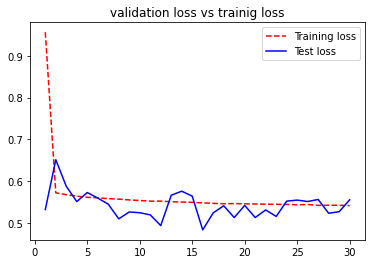

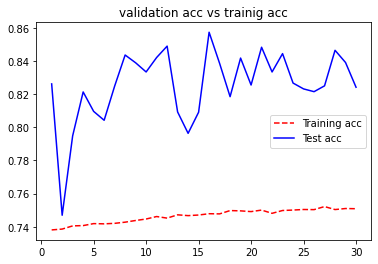

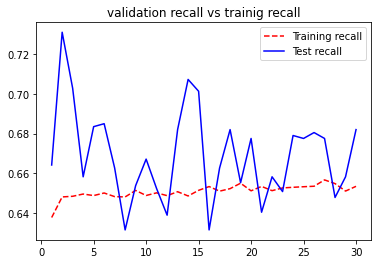

<Figure size 432x288 with 0 Axes>

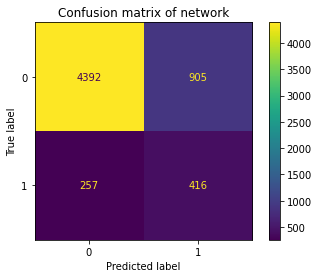

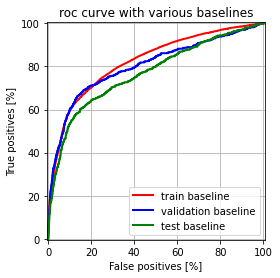

In [ ]:
columns_train = columns_to_standardized
no_features = len(columns_train)
units = [512, 256, 64]
dropouts = [0.2, 0.2, 0.1]
network = create_network_for_binary_classification_only_3_hidden_layers(no_features, 
                                                                        units,
                                                                        regularization=regularizers.l2(0.02),
                                                                        dropouts_each_layer=dropouts)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [lr_callback,  EarlyStopping(monitor='val_loss', patience=15) ]
history = network.fit(train_data[0], 
                      train_data[1],
                      epochs = 30,
                      verbose=1,
                      batch_size=64,
                      validation_data=val_data,
                      callbacks=callbacks
                      )
training_loss, test_loss, epoch_count = get_information_for_plot(history, 'loss')
training_acc, test_acc, epoch_count = get_information_for_plot(history, 'accuracy')
training_recall, test_recall, epoch_count = get_information_for_plot(history, 'recall')
plot_train_test_comparison(training_loss, test_loss, epoch_count)
plot_train_test_comparison(training_acc, test_acc, epoch_count, metric_title="acc")
plot_train_test_comparison(training_recall, test_recall, epoch_count, metric_title="recall")
plot_confusion_matrix(network, test_data)

plt.figure()
plot_roc("train baseline", train_data[1], network.predict(train_data[0]), color='r')
plot_roc("validation baseline", val_data[1], network.predict(val_data[0]), color='b')
plot_roc("test baseline", test_data[1], network.predict(test_data[0]), color='g')
plt.legend(loc='lower right');
plt.title('roc curve with various baselines')

Epoch 1/30
773/773 [==============================] - 4s 4ms/step - loss: 0.8177 - accuracy: 0.7444 - recall: 0.6547 - auc: 0.8033 - val_loss: 0.5629 - val_accuracy: 0.8126 - val_recall: 0.6835 - val_auc: 0.8031 - lr: 0.0010
Epoch 2/30
773/773 [==============================] - 2s 3ms/step - loss: 0.5520 - accuracy: 0.7494 - recall: 0.6568 - auc: 0.8132 - val_loss: 0.4638 - val_accuracy: 0.8623 - val_recall: 0.6062 - val_auc: 0.7988 - lr: 0.0010
Epoch 3/30
773/773 [==============================] - 3s 3ms/step - loss: 0.5458 - accuracy: 0.7527 - recall: 0.6678 - auc: 0.8208 - val_loss: 0.4548 - val_accuracy: 0.8653 - val_recall: 0.5840 - val_auc: 0.7935 - lr: 0.0010
Epoch 4/30
773/773 [==============================] - 3s 3ms/step - loss: 0.5399 - accuracy: 0.7581 - recall: 0.6834 - auc: 0.8293 - val_loss: 0.5082 - val_accuracy: 0.8407 - val_recall: 0.6300 - val_auc: 0.7931 - lr: 0.0010
Epoch 5/30
773/773 [==============================] - 3s 3ms/step - loss: 0.5333 - accuracy: 0.7643 

Text(0.5, 1.0, 'roc curve with various baselines')

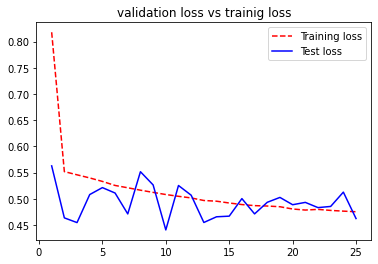

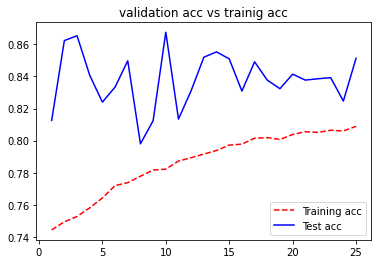

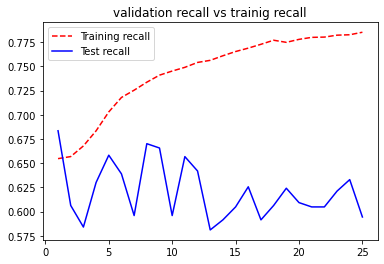

<Figure size 432x288 with 0 Axes>

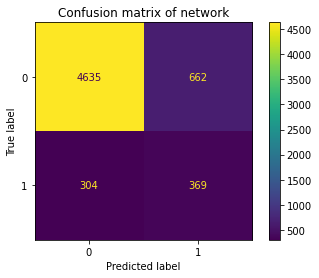

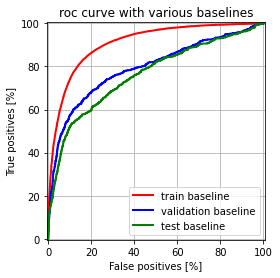

In [ ]:
columns_train = columns_to_standardized
no_features = len(columns_train)
units = [256, 256, 64]
dropouts = [0.1, 0.1, 0.1]
network = create_network_for_binary_classification_only_3_hidden_layers(no_features, 
                                                                        units,
                                                                        regularization=regularizers.l2(0.01),
                                                                        dropouts_each_layer=dropouts)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [lr_callback,  EarlyStopping(monitor='val_loss', patience=15) ]
history = network.fit(train_data[0], 
                      train_data[1],
                      epochs = 30,
                      verbose=1,
                      batch_size=64,
                      validation_data=val_data,
                      callbacks=callbacks
                      )
training_loss, test_loss, epoch_count = get_information_for_plot(history, 'loss')
training_acc, test_acc, epoch_count = get_information_for_plot(history, 'accuracy')
training_recall, test_recall, epoch_count = get_information_for_plot(history, 'recall')
plot_train_test_comparison(training_loss, test_loss, epoch_count)
plot_train_test_comparison(training_acc, test_acc, epoch_count, metric_title="acc")
plot_train_test_comparison(training_recall, test_recall, epoch_count, metric_title="recall")
plot_confusion_matrix(network, test_data)

plt.figure()
plot_roc("train baseline", train_data[1], network.predict(train_data[0]), color='r')
plot_roc("validation baseline", val_data[1], network.predict(val_data[0]), color='b')
plot_roc("test baseline", test_data[1], network.predict(test_data[0]), color='g')
plt.legend(loc='lower right');
plt.title('roc curve with various baselines')

# Final Model Visualzation 

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

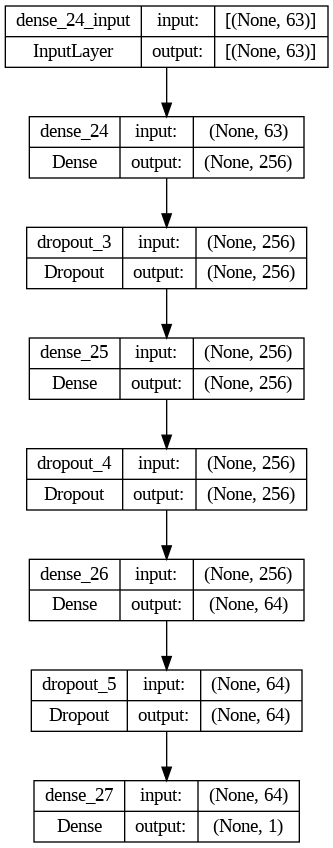

In [ ]:
# model_to_dot(, show_shapes=True).create(prog="dot", format='svg')
plot_model(network, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
SVG()

<IPython.core.display.SVG object>

# Some correlation matrix on final dataset

Text(0.5, 1.05, 'Correlation Matrix')

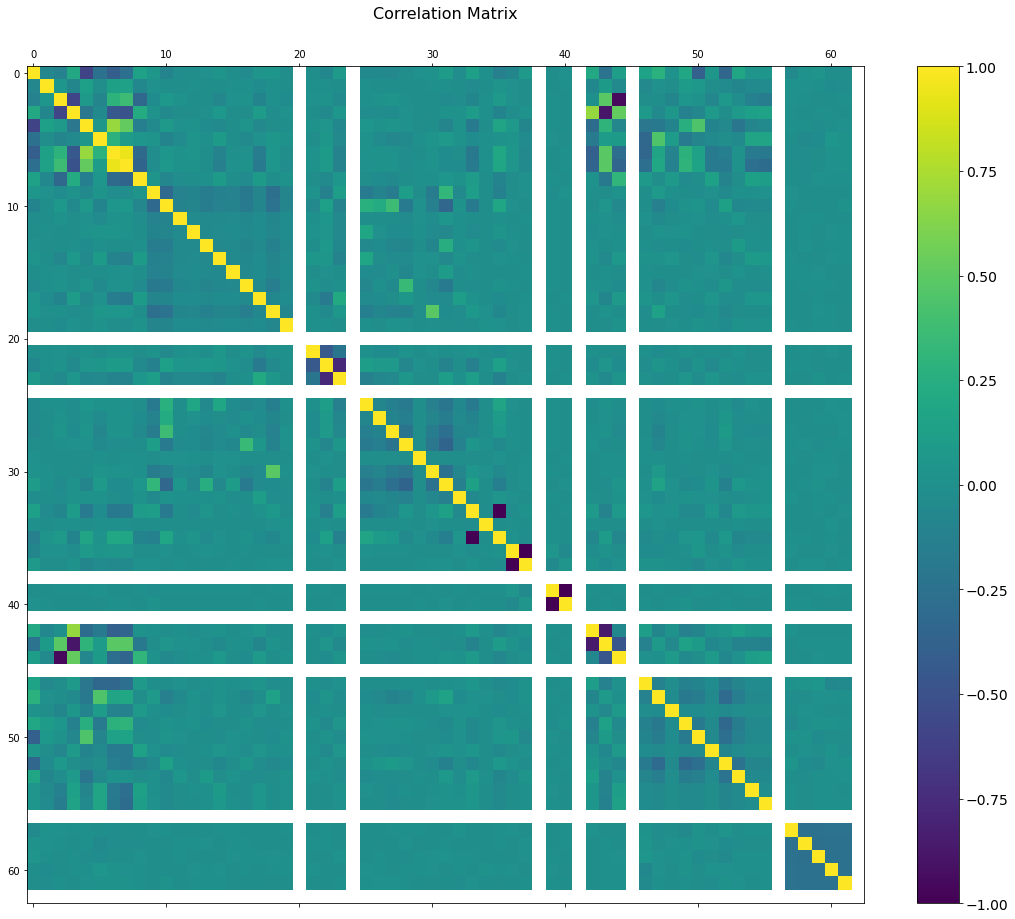

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))

plt.matshow(chosen_df.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [ ]:
chosen_df.corr()

,contact,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,...,month_nov,month_oct,month_sep,month_nan,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,day_of_week_nan
contact,1.000000,-0.078100,-0.116640,0.210581,-0.590236,-0.251747,-0.396940,-0.266246,0.143120,0.056653,...,0.180984,0.040579,0.050319,NaN,-0.040989,0.015935,0.041614,-0.005205,-0.013147,NaN
campaign,-0.078100,1.000000,0.052189,-0.079328,0.128136,-0.013920,0.135333,0.144273,-0.065781,0.012116,...,-0.079305,-0.048722,-0.033541,NaN,0.026794,0.013378,0.005417,-0.024054,-0.021596,NaN
pdays,-0.116640,0.052189,1.000000,-0.585718,0.079484,-0.093134,0.295611,0.370738,-0.324970,-0.025315,...,-0.018433,-0.123161,-0.150767,NaN,0.014048,0.002021,-0.010142,-0.006683,0.001122,NaN
previous,0.210581,-0.079328,-0.585718,1.000000,-0.203249,-0.051388,-0.452636,-0.498682,0.227512,0.017983,...,0.081925,0.125141,0.149883,NaN,0.004199,-0.003025,0.001823,0.000209,-0.003137,NaN
cons.price.idx,-0.590236,0.128136,0.079484,-0.203249,1.000000,0.061649,0.687709,0.521224,-0.135340,-0.040000,...,-0.215193,-0.091052,-0.046457,NaN,0.000807,0.002796,-0.017963,0.003567,0.011171,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
day_of_week_mon,0.015935,0.013378,0.002021,-0.003025,0.002796,-0.040586,-0.022466,-0.017249,-0.020551,-0.000442,...,-0.016764,-0.008121,-0.013278,NaN,-0.247584,1.000000,-0.262900,-0.251994,-0.253179,NaN
day_of_week_thu,0.041614,0.005417,-0.010142,0.001823,-0.017963,-0.026315,-0.014362,-0.003402,0.013000,-0.004351,...,0.007457,0.006170,0.001363,NaN,-0.249706,-0.262900,1.000000,-0.254154,-0.255349,NaN
day_of_week_tue,-0.005205,-0.024054,-0.006683,0.000209,0.003567,0.049032,0.024375,0.011723,0.007414,-0.000341,...,0.001322,0.003608,0.003289,NaN,-0.239348,-0.251994,-0.254154,1.000000,-0.244756,NaN
day_of_week_wed,-0.013147,-0.021596,0.001122,-0.003137,0.011171,0.021322,0.028874,0.022494,0.006864,-0.002958,...,0.012024,-0.003681,0.005012,NaN,-0.240473,-0.253179,-0.255349,-0.244756,1.000000,NaN
